In [1]:
!pip install tensorflow_addons

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import matplotlib.pyplot as plt
import os
import seaborn as sns

import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np

/home/melibuntu/.cache/pypoetry/virtualenvs/app-5-z5h2xa-py3.9/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.3 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [200]:
BATCH_SIZE = 32
EPOCHS = 100
PATIENCE = 20
HEIGTH = 224
WIDTH = 224
DEPTH = 1

In [25]:
# Remove possible corrupted images

from tensorflow.io import read_file, write_file
from tensorflow.image import decode_image

should_rewrite_image = True # set to true if you are getting Corrupt Data error
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join('cats_dogs/PetImages', folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        is_jfif = True
        should_remove = False
        
        with open(fpath, "rb") as fobj:
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
            
        try:
            img = read_file(fpath)
            if not tf.io.is_jpeg(img):
                should_remove = True
                
            img = decode_image(img)

            if img.ndim != 3:
                should_remove = True

        except Exception as e:
            should_remove = True
        
        if (not is_jfif) or should_remove:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
        elif should_rewrite_image:
            tmp = tf.io.encode_jpeg(img)
            write_file(fpath, tmp)

print("Deleted %d images" % num_skipped)

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Deleted 1563 images


In [29]:
cats_examples = len(os.listdir("cats_dogs/PetImages/Cat"))

In [30]:
dogs_examples = len(os.listdir("cats_dogs/PetImages/Dog"))

In [32]:
FULL_SIZE = cats_examples + dogs_examples
FULL_SIZE

23407

In [201]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "cats_dogs/PetImages/",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(HEIGTH, WIDTH),
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "cats_dogs/PetImages/",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(HEIGTH, WIDTH),
    batch_size=BATCH_SIZE
)

Found 23407 files belonging to 2 classes.
Using 18726 files for training.
Found 23407 files belonging to 2 classes.
Using 4681 files for validation.


In [35]:
skip = np.random.randint(0, FULL_SIZE, ())
for images in train_ds.unbatch().skip(skip).take(1):
    test_image = images[0]
    test_image_label = images[1]

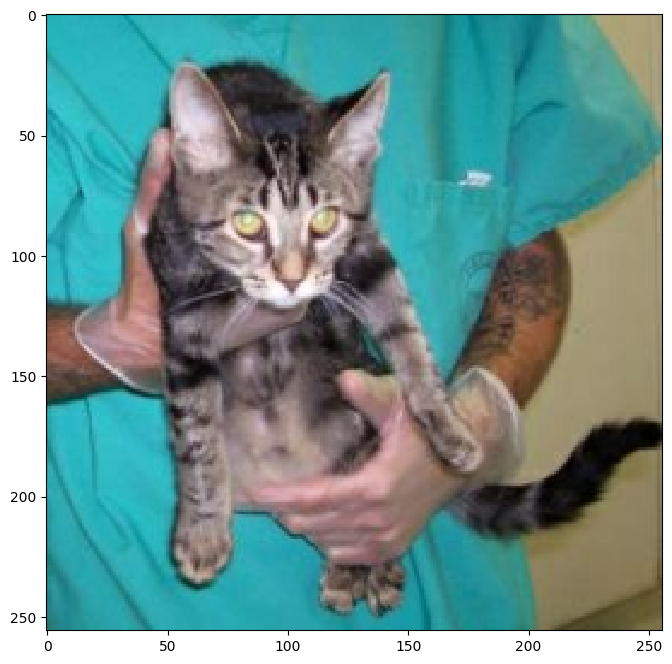

In [38]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(test_image * 1. / 255, aspect="equal", interpolation='nearest')

In [39]:
test_image_label

<tf.Tensor: shape=(), dtype=int32, numpy=0>

In [47]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [49]:
modelo_naive = tf.keras.models.Sequential(
    [
        tf.keras.layers.Rescaling(1. / 255, input_shape=(HEIGTH, WIDTH, 3)),
        tf.keras.layers.RandomFlip(mode="horizontal_and_vertical",),
        tf.keras.layers.RandomRotation(factor=0.25),
        tf.keras.layers.RandomZoom((0.2, .5), (0.2, .5)),
        tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding="same", activation="relu"),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(.5),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(.5),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ]

)

In [50]:
modelo_naive.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 random_flip_3 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation_3 (RandomRo  (None, 256, 256, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_3 (RandomZoom)  (None, 256, 256, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                 

In [191]:
modelo_naive.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(lr=5e-4), metrics="accuracy")
callbacks = [tf.keras.callbacks.EarlyStopping(patience=PATIENCE, restore_best_weights=True)]

/home/melibuntu/.cache/pypoetry/virtualenvs/app-5-z5h2xa-py3.9/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = modelo_naive.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/100
586/586 [==============================] - 26s 41ms/step - loss: 0.1940 - accuracy: 0.9192 - val_loss: 0.2483 - val_accuracy: 0.8943
Epoch 2/100
586/586 [==============================] - 26s 45ms/step - loss: 0.1953 - accuracy: 0.9190 - val_loss: 0.2253 - val_accuracy: 0.9045
Epoch 3/100
586/586 [==============================] - 25s 42ms/step - loss: 0.1950 - accuracy: 0.9211 - val_loss: 0.2364 - val_accuracy: 0.8968
Epoch 4/100
586/586 [==============================] - 25s 42ms/step - loss: 0.1886 - accuracy: 0.9238 - val_loss: 0.2227 - val_accuracy: 0.9084
Epoch 5/100
586/586 [==============================] - 26s 45ms/step - loss: 0.1907 - accuracy: 0.9191 - val_loss: 0.2208 - val_accuracy: 0.9002
Epoch 6/100
586/586 [==============================] - 24s 41ms/step - loss: 0.1848 - accuracy: 0.9218 - val_loss: 0.2294 - val_accuracy: 0.8996
Epoch 7/100
586/586 [==============================] - 24s 42ms/step - loss: 0.1861 - accuracy: 0.9228 - val_loss: 0.2202 - val_ac

In [54]:
modelo_naive.save("cats_vs_dogs/modelo_naive")

2024-04-18 23:21:22.445007: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: cats_vs_dogs/modelo_naive/assets


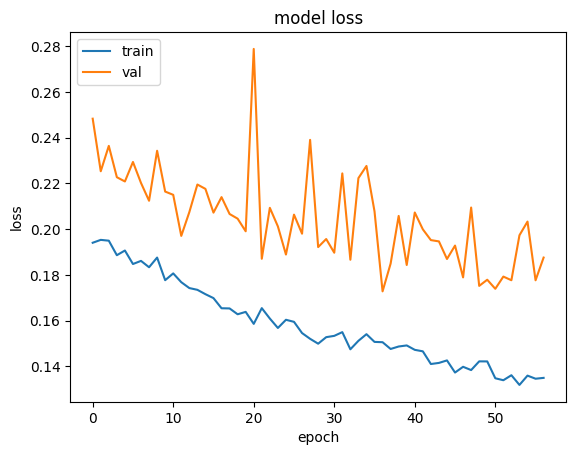

In [194]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [60]:
conv_1 = modelo_naive.layers[4]
conv_2 = modelo_naive.layers[6]
conv_3 = modelo_naive.layers[8]
conv_4 = modelo_naive.layers[10]
conv_5 = modelo_naive.layers[12]
conv_6 = modelo_naive.layers[14]

conv_1, conv_2, conv_3, conv_4, conv_5, conv_6

(<keras.layers.convolutional.Conv2D at 0x7f14e06a8f70>,
 <keras.layers.convolutional.Conv2D at 0x7f14e06da7c0>)

In [62]:
intermediate_models = []
for conv_layer in (conv_1, conv_2, conv_3, conv_4, conv_5, conv_6):
    intermediate_model = tf.keras.Model(
        inputs=modelo_naive.input,
        outputs=conv_layer.output
    )
    intermediate_models.append(intermediate_model)

In [63]:
intermediate_models

In [142]:
skip = np.random.randint(0, FULL_SIZE, ())
test_example = train_ds.unbatch().batch(1).skip(skip).take(1)
for images in test_example:
    test_image = images[0]
    test_image_label = images[1]

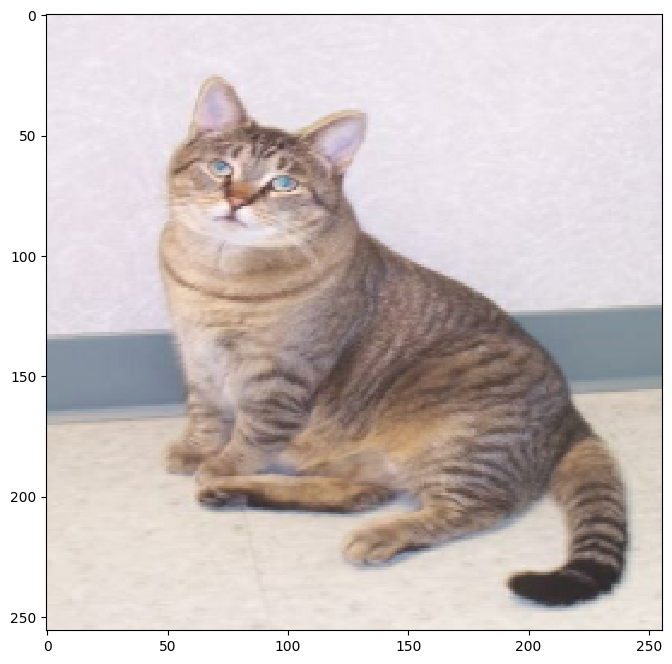

In [143]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(np.squeeze(test_image) * 1. / 255, aspect="equal", interpolation='nearest')

In [144]:
test_image.shape

TensorShape([1, 256, 256, 3])

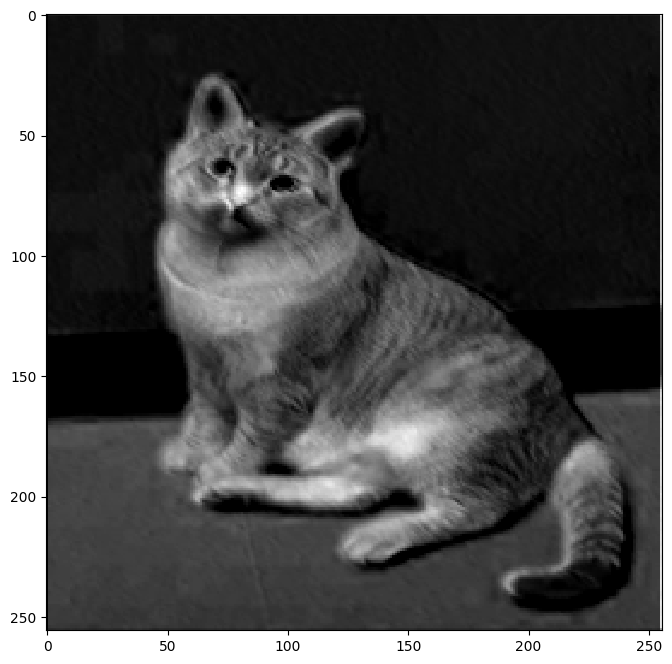

In [153]:
fig = plt.figure(figsize=(8, 8))
filter_number = np.random.randint(0, intermediate_models[0].layers[-1].filters, ())
plt.imshow(intermediate_models[0].predict(test_image)[0, :, :, filter_number], aspect="equal", interpolation='nearest', cmap='gray')

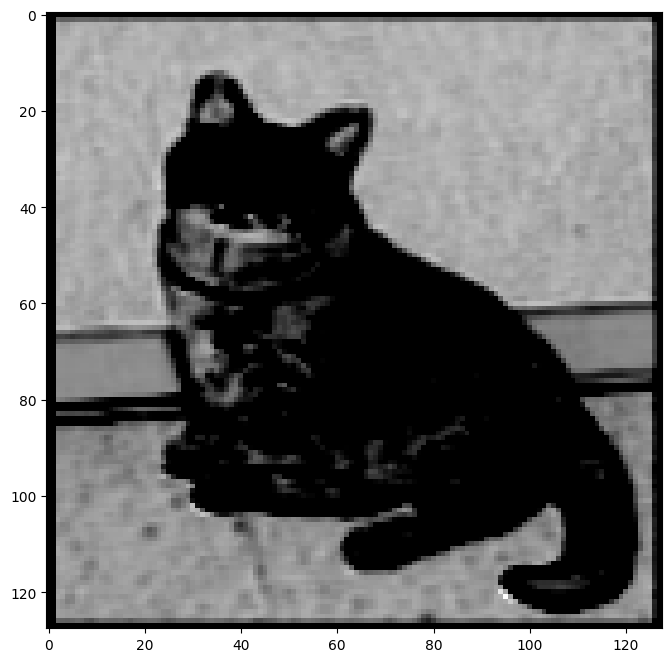

In [161]:
fig = plt.figure(figsize=(8, 8))
filter_number = np.random.randint(0, intermediate_models[1].layers[-1].filters, ())
plt.imshow(intermediate_models[1].predict(test_image)[0, :, :, filter_number], aspect="equal", interpolation='nearest', cmap='gray')

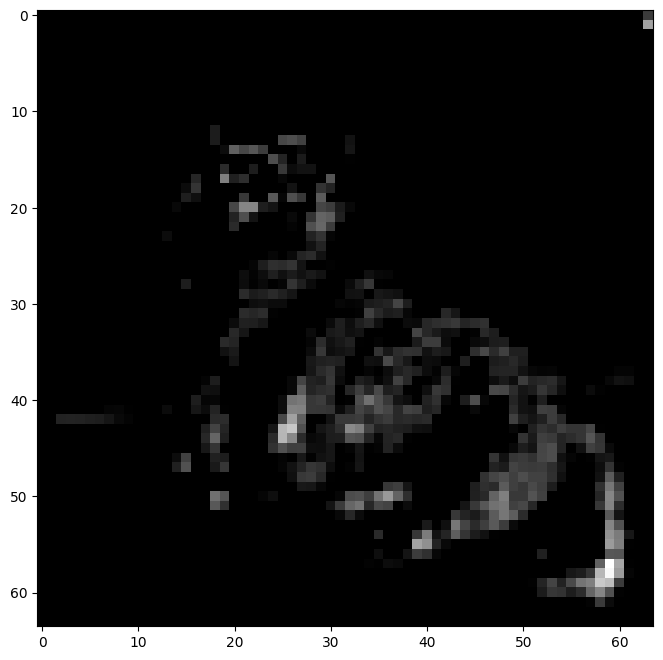

In [179]:
fig = plt.figure(figsize=(8, 8))
filter_number = np.random.randint(0, intermediate_models[2].layers[-1].filters, ())
plt.imshow(intermediate_models[2].predict(test_image)[0, :, :, filter_number], aspect="equal", interpolation='nearest', cmap='gray')

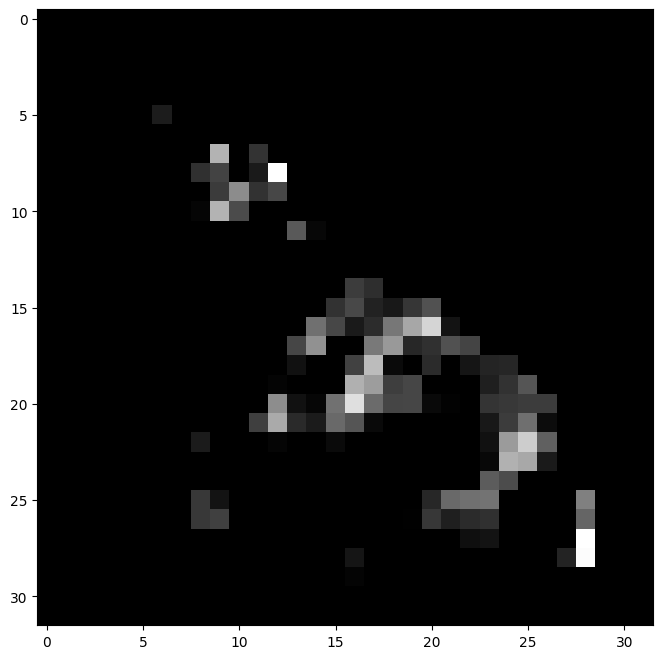

In [180]:
fig = plt.figure(figsize=(8, 8))
filter_number = np.random.randint(0, intermediate_models[3].layers[-1].filters, ())
plt.imshow(intermediate_models[3].predict(test_image)[0, :, :, filter_number], aspect="equal", interpolation='nearest', cmap='gray')

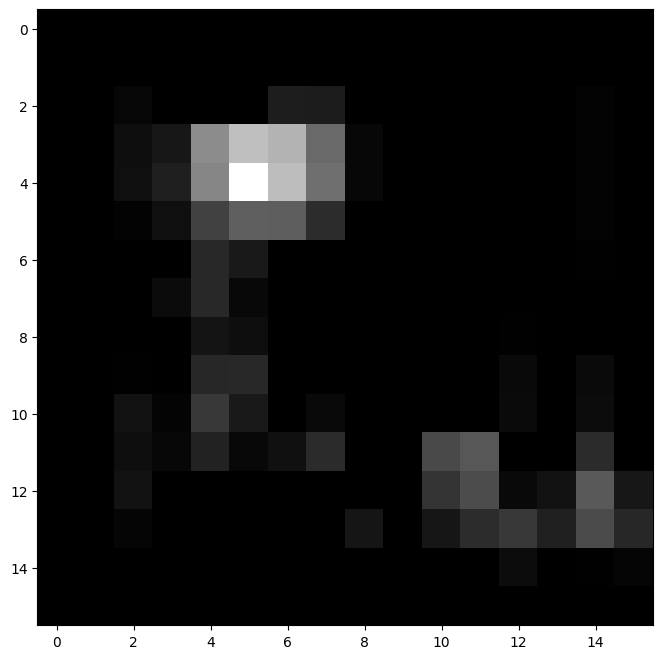

In [187]:
fig = plt.figure(figsize=(8, 8))
filter_number = np.random.randint(0, intermediate_models[4].layers[-1].filters, ())
plt.imshow(intermediate_models[4].predict(test_image)[0, :, :, filter_number], aspect="equal", interpolation='nearest', cmap='gray')

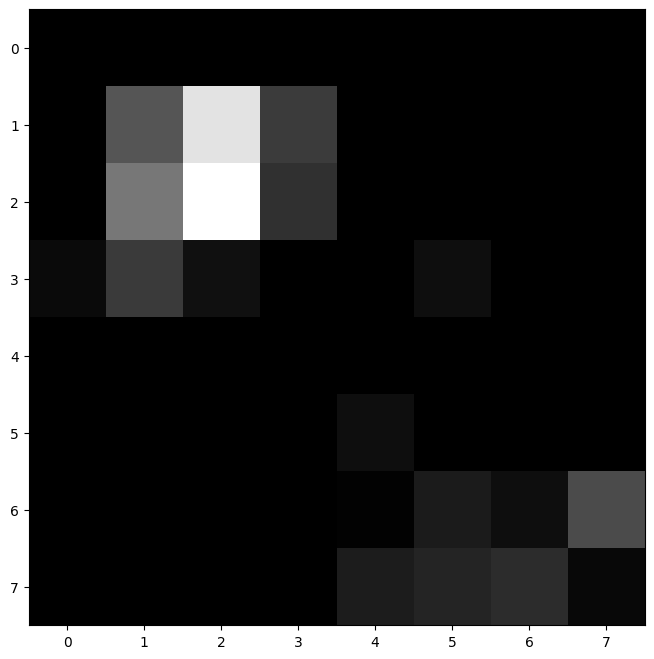

In [189]:
fig = plt.figure(figsize=(8, 8))
filter_number = np.random.randint(0, intermediate_models[5].layers[-1].filters, ())
plt.imshow(intermediate_models[5].predict(test_image)[0, :, :, filter_number], aspect="equal", interpolation='nearest', cmap='gray')

In [195]:
from tensorflow.keras.applications import EfficientNetB1

In [204]:
efficientnet_model = EfficientNetB1(include_top=False, input_shape=(HEIGTH, WIDTH, 3))

In [205]:
efficientnet_model.trainable = False

In [210]:
transferlearning_model = tf.keras.models.Sequential([
    efficientnet_model,
    tf.keras.layers.GlobalAveragePooling2D(name="avg_pool"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [211]:
transferlearning_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional)  (None, 7, 7, 1280)       6575239   
                                                                 
 avg_pool (GlobalAveragePool  (None, 1280)             0         
 ing2D)                                                          
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense_14 (Dense)            (None, 256)               327936    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                      

In [212]:
transferlearning_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(lr=1e-3), metrics="accuracy")
callbacks = [tf.keras.callbacks.EarlyStopping(patience=PATIENCE, restore_best_weights=True)]

/home/melibuntu/.cache/pypoetry/virtualenvs/app-5-z5h2xa-py3.9/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [213]:
history_2 = transferlearning_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/100
586/586 [==============================] - 41s 53ms/step - loss: 0.0481 - accuracy: 0.9833 - val_loss: 0.0316 - val_accuracy: 0.9906
Epoch 2/100
586/586 [==============================] - 28s 48ms/step - loss: 0.0319 - accuracy: 0.9893 - val_loss: 0.0301 - val_accuracy: 0.9897
Epoch 3/100
586/586 [==============================] - 28s 47ms/step - loss: 0.0241 - accuracy: 0.9910 - val_loss: 0.0336 - val_accuracy: 0.9904
Epoch 4/100
586/586 [==============================] - 28s 47ms/step - loss: 0.0204 - accuracy: 0.9929 - val_loss: 0.0318 - val_accuracy: 0.9912
Epoch 5/100
586/586 [==============================] - 28s 48ms/step - loss: 0.0176 - accuracy: 0.9941 - val_loss: 0.0285 - val_accuracy: 0.9902
Epoch 6/100
586/586 [==============================] - 28s 47ms/step - loss: 0.0171 - accuracy: 0.9936 - val_loss: 0.0367 - val_accuracy: 0.9893
Epoch 7/100
586/586 [==============================] - 28s 47ms/step - loss: 0.0146 - accuracy: 0.9955 - val_loss: 0.0352 - val_ac